In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, time, glob
import pyccl as ccl
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
%load_ext autoreload
%autoreload 2
sys.path.append('../modules/')
import abundance as cl_count
import covariance as covar
import mvp_pdf
import edit
import utils
import lnlikelihood as l
import importance_sampling as imp_samp
#sys.path.append('../modules/pinocchio_analysis/')
#import compute_mean_covariance_importance_sampling as Oms8
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

In [2]:
n_z_bin=4
n_m_bin=4

# Binned cluster abundance for the 1000 Pinocchio simualtions

In [3]:
#binned cluster abundance for the 1000 simualtions
dat = edit.load_pickle(f'/sps/lsst/users/cpayerne/1000xsimulations/analysis/binned_catalogs/{n_z_bin}x{n_m_bin}_binned_catalogs.pkl')
Nobs = np.array(dat[3])

In [4]:
Nobs.shape

(1000, 4, 4)

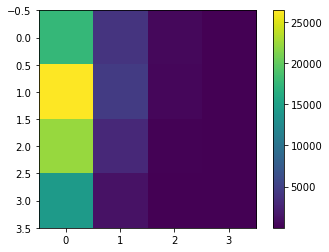

In [5]:
plt.imshow(Nobs[0])
plt.colorbar()

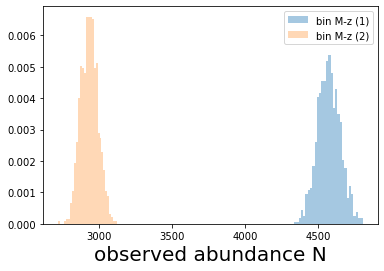

In [6]:
plt.hist(Nobs[:,1,1], density = True, bins = 30, alpha = .4, label = 'bin M-z (1)')
plt.hist(Nobs[:,2,1], density = True, bins = 30, alpha = .3,  label = 'bin M-z (2)')
plt.xlabel('observed abundance N', fontsize = 20)
plt.legend()
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/hist.png', bbox_inches='tight', dpi=300)
plt.show()

# Importance Sampling
## Posterior to estimate

$$
p(\vec{\theta}) = \mathcal{L}(\vec{\widehat{N}}|\vec{N}(\vec{\theta}))\ \pi(\vec{\theta})
$$

## pre-tabulated abundance $\vec{N}(\vec{\theta})$ and $q(\vec{\theta})$ on random position $\vec{\theta} \sim q$

In [7]:
ratio_f_sky = 1
where_tab=f'/sps/lsst/users/cpayerne/1000xsimulations/analysis/'
key=f'{n_z_bin}zx{n_m_bin}m/tabulated_model/{n_z_bin}x{n_m_bin}_sampled_abundance_'
where=where_tab+key+'*'
Nth, Om, s8, q_val=[],[],[],[]
for f in glob.glob(where):
    sampled_model=np.array(edit.load_hdf5(f))
    q=sampled_model['q']
    Nth.extend(ratio_f_sky * sampled_model['abundance'])
    q_val.extend(list(sampled_model['q']))
    Om.extend(list(sampled_model['Om']))
    s8.extend(list(sampled_model['s8']))

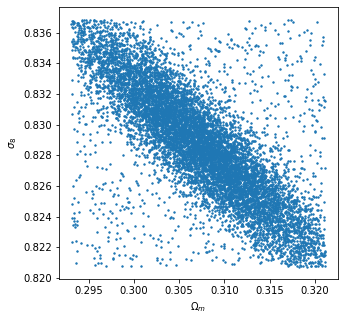

In [8]:
#proposition
plt.figure(figsize = (5,5))
plt.scatter(Om, s8, s = 2)
plt.ylabel(r'$\sigma_8$')
plt.xlabel(r'$\Omega_m$')
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/q.png', bbox_inches='tight', dpi=300)
plt.show()

## Evaluationg posterior $p(\vec{\theta}|\vec{\widehat{N}})$ at the $\vec{\theta} \sim q$ random positions & compute weights  $w = p/q$

$$
p(\vec{\theta}) = \mathcal{L}(\vec{\widehat{N}}|\vec{N}(\vec{\theta}))\ \pi(\vec{\theta})
$$

In [9]:
lnL=l.lnLikelihood(theory=None)
likelihood='Poissonian'
def lnposterior(model, data):
    #define the posterior
    return lnL.lnPosterior(model, data, likelihood=likelihood)

res=imp_samp.compute_mean_covariance_importance_sampling(lnposterior, Nobs[3], Nth,
                                                     Om=Om, s8=s8, q_val=q_val, 
                                                     mp=False, browse=False)

In [10]:
res

array([0.3033422191071872, 0.8309442110993284,
       array([[ 3.63183770e-06, -2.00651253e-06],
              [-2.00651253e-06,  1.34629052e-06]])], dtype=object)

### Gaussian

In [11]:
Covariance=edit.load_pickle(f'/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Covariance_cluster_abudance_{n_z_bin}x{n_m_bin}.pickle')
Cholesky=np.linalg.cholesky(Covariance*ratio_f_sky)
inv_L = np.linalg.inv(Cholesky)
theory={'inv_L':inv_L}

In [12]:
lnL=l.lnLikelihood(theory=theory)
likelihood='GaussianCholesky'
def lnposterior(model, data):
    #define the posterior
    return lnL.lnPosterior(model, data, likelihood=likelihood)
ti=time.time()
print(lnposterior(Nth[28], Nobs[1]))
tf=time.time()
print(tf-ti)

-11.062256381218383
0.0005452632904052734


In [13]:
0.05*10000/60

8.333333333333334

In [14]:
res=imp_samp.compute_mean_covariance_importance_sampling(lnposterior, Nobs[1], Nth,
                                                     Om=Om, s8=s8, q_val=q_val, 
                                                     mp=True, browse=False)

You have 3 CPUs


In [15]:
res

array([0.31230670114093534, 0.8256103968340376,
       array([[ 5.81338160e-06, -2.93804860e-06],
              [-2.93804860e-06,  1.87444103e-06]])], dtype=object)

### MVP

In [16]:
Sample_covariance=edit.load_pickle(f'/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Sample_covariance_full_{n_z_bin}x{n_m_bin}.pickle')
Halo_bias=edit.load_pickle(f'/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Halo_bias_{n_z_bin}x{n_m_bin}.pickle')
Sij=edit.load_pickle(f'/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Sij_partialsky_{n_z_bin}x{n_m_bin}.pickle')

In [23]:
theory={'S_ij':(1./ratio_f_sky)*Sij,  
        'Halo_bias':Halo_bias, 'inv_L': inv_L}

In [24]:
lnL=l.lnLikelihood(theory=theory)
likelihood='MPG'
def lnposterior(model, data):
    #define the posterior
    return lnL.lnPosterior(model, data, likelihood=likelihood)
ti=time.time()
print(lnposterior(Nth[28], Nobs[1]))
tf=time.time()
print(tf-ti)

-75.92131469134054
0.23470520973205566


# Example: 10 simulations

# Compute weights

In [25]:
#res = imp_samp.compute_posterior(posterior = lnposterior_MPG, model_tab = Nth, data = Nobs[1], mp = True)

In [26]:
likelihood='GaussianCholesky'
def lnposterior(model, data):
    #define the posterior
    return lnL.lnPosterior(model, data, likelihood=likelihood)

In [27]:
n_test = 4
def compute_weights(n, mp=False):
    res=np.array([lnposterior(model, Nobs[n]) for model in Nth])
    res=res-np.min(res)
    w=np.exp(res)/q_val
    w=w/np.max(w)
    return w

In [28]:
weights = [compute_weights(n, mp=False) for n in range(n_test)]

In [29]:
#weights = np.array(utils.map(compute_weights, np.arange(n_test), ncores=8, ordered=True, progress=True))

# Weighted histograms

In [30]:
import random
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(n_test)]

Text(0, 0.5, '$\\sigma_8$')

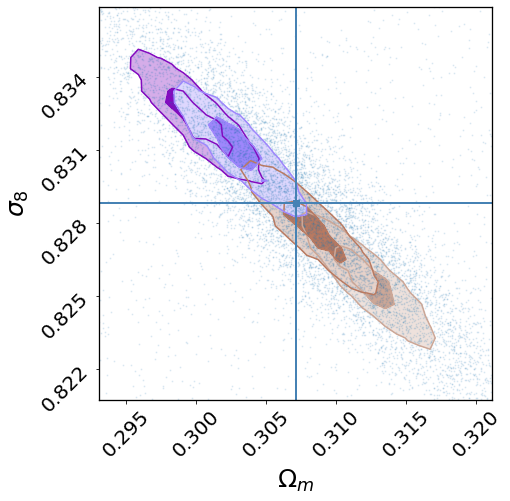

In [32]:
import corner
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
fig, axs = plt.subplots(2,2, figsize = (15,15), sharex = True, sharey = True)
pos_emcee = [[a_,b_] for a_, b_ in zip(Om,s8)]
bins = 35
# corner.corner(pos_emcee, fig = fig,
#           bins=20, levels=(sigma1, sigma2), 
#           fill_contours=False, plot_contours = True,
#           label_kwargs={"fontsize": 20}, top_ticks = True,
#           plot_density=False,
#           max_n_ticks = 6,
#           scale_hist = True,
#           plot_datapoints=False,
#         color = 'k')
#axs[1,0].plot([],[], color='k', label = f'proposal q')
for i in range(n_test):

    axs[1,0].plot([],[], color=color[i], )#l)#abel = f'Pinocchio-{i}')
    corner.corner(pos_emcee, fig = fig, weights=weights[i]/np.sum(weights[i]),
                  bins=bins, levels=(sigma1, sigma2), 
                  fill_contours=True
                  , plot_contours = True,
                  label_kwargs={"fontsize": 20}, top_ticks = True,
                  plot_density=False,
                  max_n_ticks = 6,
                  scale_hist = True,
                  alpha=1,
                  plot_datapoints=False,
                color = color[i], #range = [(0.294, 0.320), (0.820, 0.8375)],
                  truths = True_value)
axs[1,0].scatter(Om, s8, s=1, alpha=.1)
axs[1,0].set_xlabel(r'$\Omega_m$', labelpad=7, fontsize = 25)
axs[1,0].set_ylabel(r'$\sigma_8$', labelpad=7, fontsize = 25)
#axs[1,0].legend(frameon = True, fontsize = 16)
plt.rcParams['axes.linewidth'] = 1.3
axs[1,0].tick_params(axis='both', which = 'major', labelsize= 20)
fig.delaxes(axs[0,0])
fig.delaxes(axs[0,1])
fig.delaxes(axs[1,1])

# for i in range(n_test):
#     w = weights[i]
#     mean, dispersion = imp_samp.compute_mean_and_dispersion(np.array(pos_emcee), w)
#     cov = np.cov(Om, s8, rowvar=1, bias=0, fweights=None, aweights=w)
#     utils._make_ellipse(mean, cov, axs[1,1], level=0.95, color=color[i], label = 'r', ls = '-')
axs[1,1].tick_params(axis='both', which = 'major', labelsize= 20)
axs[1,1].set_xlabel(r'$\Omega_m$', labelpad=7, fontsize = 25)
axs[1,1].set_ylabel(r'$\sigma_8$', labelpad=7, fontsize = 25)
#plt.savefig('importance_sampling_cluster_count.pdf', bbox_inches='tight', dpi=300)

Text(0, 0.5, '$\\sigma_8$')

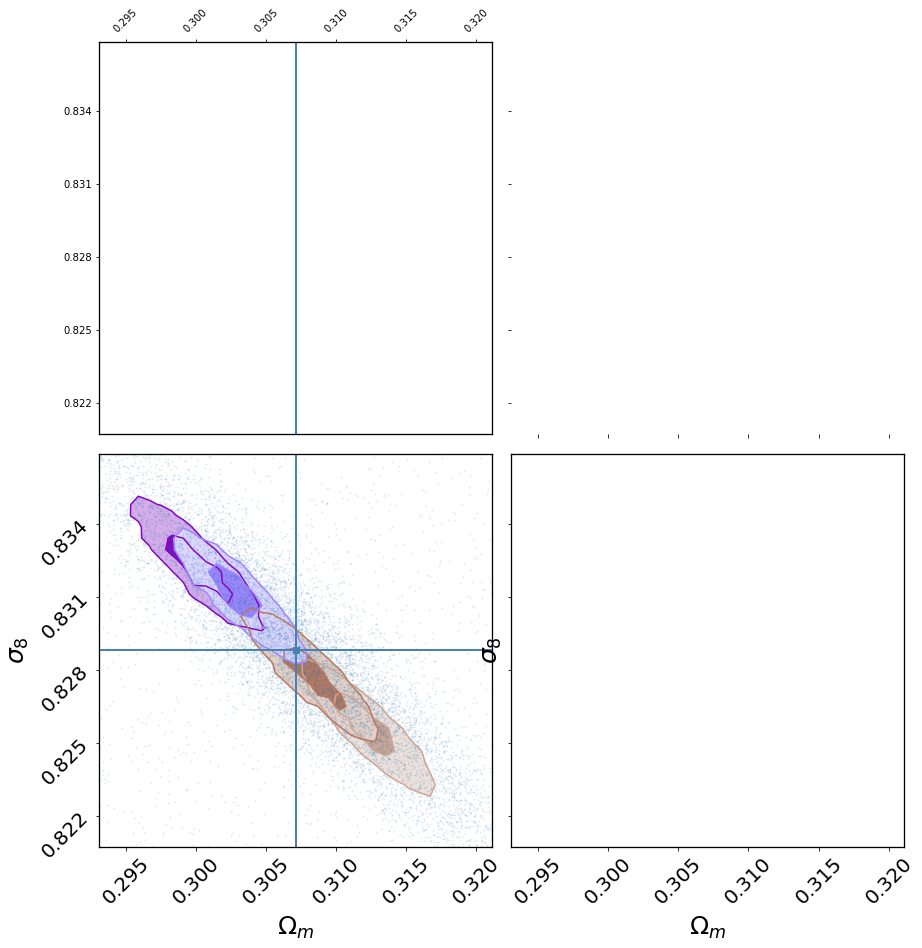

In [38]:
import corner
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
fig, axs = plt.subplots(2,2, figsize = (15,15), sharex = True, sharey = True)
pos_emcee = [[a_,b_] for a_, b_ in zip(Om,s8)]
bins = 35
for i in range(n_test):

    axs[1,0].plot([],[], color=color[i], )#l)#abel = f'Pinocchio-{i}')
    corner.corner(pos_emcee, fig = fig, weights=weights[i]/np.sum(weights[i]),
                  bins=bins, levels=(sigma1, sigma2), 
                  fill_contours=True
                  , plot_contours = True,
                  label_kwargs={"fontsize": 20}, top_ticks = True,
                  plot_density=False,
                  max_n_ticks = 6,
                  scale_hist = True,
                  alpha=1,
                  plot_datapoints=False,
                color = color[i], #range = [(0.294, 0.320), (0.820, 0.8375)],
                  truths = True_value)
    plt.hist(Om, weights=weights[i]/np.sum(weights[i]))
axs[1,0].scatter(Om, s8, s=1, alpha=.1)
axs[1,0].set_xlabel(r'$\Omega_m$', labelpad=7, fontsize = 25)
axs[1,0].set_ylabel(r'$\sigma_8$', labelpad=7, fontsize = 25)
#axs[1,0].legend(frameon = True, fontsize = 16)
plt.rcParams['axes.linewidth'] = 1.3
axs[1,0].tick_params(axis='both', which = 'major', labelsize= 20)

axs[1,1].tick_params(axis='both', which = 'major', labelsize= 20)
axs[1,1].set_xlabel(r'$\Omega_m$', labelpad=7, fontsize = 25)
axs[1,1].set_ylabel(r'$\sigma_8$', labelpad=7, fontsize = 25)
#plt.savefig('importance_sampling_cluster_count.pdf', bbox_inches='tight', dpi=300)

In [ ]:
plt.hist(Om, weights=weights[1], density=True,bins=100, alpha=.5)
plt.hist(Om, weights=weights[2],density=True, bins=200, alpha=.5)
plt.hist(Om, weights=weights[3],density=True, bins=200, alpha=.5)
plt.show()

In [ ]:
weights[:,1]

In [ ]:
utils.weightedcovar(Om, s8, w=weights[1,:])